In [590]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100

import seaborn as sns
import pandas_profiling as pdp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import collections
import re
import feather
import codecs

from sklearn.preprocessing import LabelEncoder

In [591]:
train=pd.read_csv('../input/train.csv')
test=pd.read_csv('../input/test.csv')
sample=pd.read_csv('../input/sample_submit.csv')

train_feat1=pd.read_feather('feature1/data/train_feat1.ftr')
test_feat1=pd.read_feather('feature1/data/test_feat1.ftr')

test_feat1.index=test_feat1['index']
test_feat1.drop(['level_0','index'],axis=1,inplace=True)

## 外れ値、ミスタイポを除去

In [592]:
train.query("id==20428 or id == 20232")

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
20231,20232,112000,東京都板橋区蓮根３丁目,都営三田線\t西台駅\t徒歩7分\t\t都営三田線\t蓮根駅\t徒歩7分,2DK+S(納戸),520年5ヶ月,南,51.3m2,3階／3階建,専用トイレ／\tバス・トイレ別／\tシャワー／\t洗面台独立,コンロ設置可（コンロ3口）／\t給湯,光ファイバー／\tCATV,エアコン付\t出窓／\tバルコニー／\tフローリング／\t室内洗濯機置場／\tタイル張り,NaN,NaN,鉄骨造,NaN
20427,20428,82000,東京都目黒区中町２丁目,東急東横線\t祐天寺駅\t徒歩11分\t\t東急東横線\t中目黒駅\t徒歩15分\t\t東急...,1DK,1019年7ヶ月,南,24m2,2階／2階建,専用トイレ／\tバス・トイレ別／\tシャワー,コンロ設置可（コンロ2口）,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室外洗濯機置場／\tタ...,NaN,NaN,鉄骨造,NaN


In [593]:
train.query("id==20927")

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
20926,20927,116000,東京都荒川区南千住７丁目,日比谷線\t南千住駅\t徒歩7分\t\t京成本線\t千住大橋駅\t徒歩10分\t\t都電荒川...,2LDK,19年11ヶ月,西,430.1m2,2階／10階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t独立キッチン,インターネット対応／\t光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 432m\t【スーパー】 532m\t【コンビニ】 111m\t【コンビニ】 ...,鉄骨造,NaN


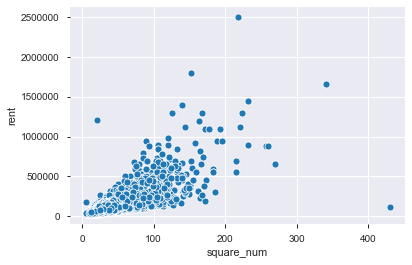

In [594]:
sns.scatterplot(train_feat1['square_num'],train_feat1['rent'])
plt.show()

In [595]:
# 外れ値、異常データを削除
train=train[train['id']!=20428][train['id']!=20232][train['id']!=20927]
train_feat1=train_feat1[train_feat1['id']!=20428][train_feat1['id']!=20232][train_feat1['id']!=20927]

train_index=len(train)
test_index=len(test)

df_all=pd.concat([train,test],axis=0,sort=False).reset_index(drop=True)
df_all.columns=['id','rent','address','access','floor_info','old','direction','square','floor','bath','kitchen','broadcast','facility','parking','neighbors','structure','period']

df_all_feat1=pd.concat([train_feat1,test_feat1],axis=0,sort=False).reset_index(drop=True)

## 経度・緯度を加える

In [596]:
with codecs.open("../input/13000-17.0a/13_2018.csv", "r", "Shift-JIS", "ignore") as file:
    df_cordA = pd.read_table(file, delimiter=",")
    display(df_cordA[:3])    
with codecs.open("../input/13000-12.0b/13_2018.csv", "r", "Shift-JIS", "ignore") as file:
    df_cordB = pd.read_table(file, delimiter=",")
    display(df_cordB[:3])
    
cordinate=df_cordA[['市区町村名','大字・丁目名','緯度','経度']]
cordinate.columns=['address_city','address_town','longitude','latitude']
cordinate.drop_duplicates(subset=['address_city','address_town'],keep='last',inplace=True)

,都道府県名,市区町村名,大字・丁目名,小字・通称名,街区符号・地番,座標系番号,Ｘ座標,Ｙ座標,緯度,経度,住居表示フラグ,代表フラグ,更新前履歴フラグ,更新後履歴フラグ
0,東京都,千代田区,麹町六丁目,NaN,1,9,-34981.8,-9228.7,35.684649,139.731373,0,1,0,0
1,東京都,千代田区,麹町六丁目,NaN,5,9,-34981.8,-9228.7,35.684649,139.731373,0,1,0,0
2,東京都,千代田区,六番町,NaN,6,9,-34653.0,-9100.3,35.687614,139.732787,0,1,0,0


,都道府県コード,都道府県名,市区町村コード,市区町村名,大字町丁目コード,大字町丁目名,緯度,経度,原典資料コード,大字・字・丁目区分コード
0,13,東京都,13101,千代田区,131010001002,内幸町二丁目,35.670812,139.754182,0,3
1,13,東京都,13101,千代田区,131010001001,内幸町一丁目,35.670839,139.758119,0,3
2,13,東京都,13101,千代田区,131010002003,霞が関三丁目,35.671825,139.746988,0,3


In [597]:
# 住所から区を取得
city_tmp=df_all['address'].apply(lambda x:x.split('都')[1])
df_all['address_city']=city_tmp.apply(lambda x:x.split('区')[0]+'区')

# 住所から町名を取得
town_tmp=city_tmp.apply(lambda x:x.split('区')[1])

def town_enc(x):
    # 番地を削除
    x=re.split(r'\d+-|ー|－+\d+',x)[0]   
    # 何丁目か分かるものと、わからないもので分類
    split_list=x.split('丁目')
    if len(split_list)==2:
        return split_list[0]+'丁目'
    else:
    # 余分な数字を削除
        town=re.split(r'\d+',split_list[0])[0]
        return town
    
def int2kanji(x):
    kanji_nums={'1':'一', '2':'二', '3':'三', '4':'四', '5':'五', '6':'六', '１':'一', '２':'二', '３':'三', '４':'四', '５':'五', '６':'六', '７':'七', '８':'八', '９':'九'}
    num=re.findall(r'\d+',x)
    if len(num)==0:
        return x
    else:
        return x.replace(num[0],kanji_nums[num[0]])
df_all['address_town']=town_tmp.apply(lambda x:town_enc(x))
df_all['address_town']=df_all['address_town'].apply(lambda x:int2kanji(x))

In [598]:
df_all=pd.merge(df_all,cordinate,on=['address_city','address_town'],how='left')

# 欠損を平均値で補完
df_all['longitude']=df_all['longitude'].fillna(np.mean(df_all['longitude']))
df_all['latitude']=df_all['latitude'].fillna(np.mean(df_all['latitude']))

## アクセスから、４駅の最寄りと距離を特徴量にいれる.

In [599]:
#  アクセス情報の初めの要素から路線と駅名をとる
df_all['train_line']=df_all['access'].apply(lambda x:x.split('\t')[0])
df_all['train_station']=df_all['access'].apply(lambda x:x.split('\t')[1])

# バス移動のものはバス特徴量にまとめる
df_all['station_access']=df_all['access'].apply(lambda x:x.split('\t')[2])
df_all['station_access']=df_all['station_access'].apply(lambda x:'車移動' if 'バス' in x or '車' in x else x)

#  数値型に変更
def enc_num(x):
    if x=='車移動':
        return 999
    else:
        return int(re.findall(f'\d+',x)[0])
    
df_all['station_access']=df_all['station_access'].apply(lambda x:enc_num(x))


In [600]:
# 最寄りの駅情報を４つに分ける
def split_access(x):
    access_list=x.split('\t\t')
    num_list=len(access_list)

    if num_list==1:
        return access_list[0],0,0,0
    elif num_list==2:
        return access_list[0],access_list[1],0,0
    elif num_list==3:
        return access_list[0],access_list[1],access_list[2],0
    else:
        return access_list[0],access_list[1],access_list[2],access_list[3]

# 各最寄り駅情報を路線、駅、移動方法に分ける
def access_enc(x,func):
    if x==0:
        return 'nan'
    else:
        split_list=x.split('\t')
    #  路線名を取得
        if func=='line':
            if '線' in split_list[0]:
                return split_list[0]
            else:
                return 'nan'

        # 駅名を取得
        elif func=='station':
            if len(split_list)>=2 and '駅' in split_list[1]: 
                return split_list[1]
            else:
                return 'nan'

        # 距離を取得
        else:
            if len(split_list)==3:
                if 'バス' in x or '車' in split_list[2]:
                    return '車移動'
                else:
                    return split_list[2]
            else:
                return 'nan'
        
#  距離を数値型に変更
def enc_num(x):

    if x=='車移動':
        return 999
    
    elif x=='nan':
        return -999
    
    else:
        return int(re.findall(f'\d+',x)[0])

tmp=df_all['access'].apply(lambda x:split_access(x))

for i in range(4):
    df_all['access_'+str(i+1)]=tmp.apply(lambda x:x[i])
    df_all['access_'+str(i+1)+'_line']=df_all['access_'+str(i+1)].apply(lambda x:access_enc(x,'line'))
    df_all['access_'+str(i+1)+'_station']=df_all['access_'+str(i+1)].apply(lambda x:access_enc(x,'station'))
    df_all['access_'+str(i+1)+'_distance']=df_all['access_'+str(i+1)].apply(lambda x:access_enc(x,'distance'))
    df_all['access_'+str(i+1)+'_distance']=df_all['access_'+str(i+1)+'_distance'].apply(lambda x:enc_num(x))

# 数値型にエンコード
for col in ['line','station']:
    le=LabelEncoder()
    encoder=list(set(df_all['access_1_'+col].unique()) | set(df_all['access_2_'+col].unique()) | \
    set(df_all['access_3_'+col].unique()) | set(df_all['access_4_'+col].unique()))
    
    le.fit(encoder)
    for i in range(4):
        df_all['access_'+str(i+1)+'_'+col]=le.transform(df_all['access_'+str(i+1)+'_'+col])
        df_all['access_'+str(i+1)+'_'+col]=df_all['access_'+str(i+1)+'_'+col].astype('category')

## 面積から統計特徴量を加える
1 単位面積あたりの価格の区ごとの平均、最大値、最小値、中央値、標準偏差を加える

In [606]:
# 訓練データだけを取り出す
tmp=pd.concat([df_all,df_all_feat1['square_num']],axis=1)[:train_index]
tmp['rent_per_square']=tmp['rent']/tmp['square_num']

# 単位面積あたりの区ごとの統計量を求める
rent_per_square_static=pd.DataFrame(tmp.groupby('address_city')['rent_per_square'].agg(['mean','max','min','median','std'])).reset_index()
rent_per_square_static.columns=['address_city','rent/S_mean','rent/S_max','rent/S_min','rent/S_median','rent/S_std']

#  全体に加える
df_all=pd.merge(df_all,rent_per_square_static,on='address_city',how='left')

2 住宅価格の区ごとの統計特徴量を加える

In [610]:
tmp=pd.concat([df_all,df_all_feat1['square_num']],axis=1)[:train_index]
rent_static=pd.DataFrame(tmp.groupby('address_city')['rent'].agg(['mean','max','min','median','std'])).reset_index()
rent_static.columns=['address_city','rent_mean','rent_max','rent_min','rent_median','rent_std']
#  全体に加える
df_all=pd.merge(df_all,rent_static,on='address_city',how='left')

## ======保存=======

In [2]:
feature1=df_all_feat1.drop(['train_line','train_station','station_access'],axis=1)
new_feature=df_all.select_dtypes(exclude='object').drop(['id','rent'],axis=1)
df_all_feat2=pd.concat([feature1,new_feature],axis=1)

NameError: name 'df_all_feat1' is not defined

In [621]:
train=df_all_feat2[:train_index]
test=df_all_feat2[train_index:]

In [627]:
train.to_feather('train_feat2.ftr')
test.reset_index(inplace=True)
test.to_feather('test_feat2.ftr')

In [1]:
train_feat1

NameError: name 'train_feat1' is not defined